### Importação de Bibliotecas

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Modelos e métricas de avaliação
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ignorando avisos
import warnings
warnings.filterwarnings("ignore")

print('Bibliotecas importadas com sucesso!')

Bibliotecas importadas com sucesso!


### Pipeline de Extração e Transformação

Foi executado um **pipeline de extração e transformação de dados**, desenvolvido para coletar informações por meio da API do Meta. Este pipeline emprega **variáveis constantes** essenciais para o projeto, garantindo a consistência e a integridade dos dados extraídos.

Embora o pipeline seja arquitetado para a **extração assíncrona de dados de múltiplas contas**, para os propósitos deste projeto, a extração foi **restrita aos dados de uma única conta**. Esta abordagem visa a centralização e otimização da análise para o escopo definido.

### Detalhes da Extração de Dados

A extração de dados do Meta Ads foi focada nas seguintes métricas, essenciais para a nossa análise:

* **`campaign_name`**: Nome da campanha.
* **`spend`**: Gasto total na campanha.
* **`inline_link_clicks`**: Número de cliques no link interno.
* **`reach`**: Alcance único da campanha.
* **`impressions`**: Número total de impressões.
* **`ctr`**: Taxa de cliques (Click-Through Rate).
* **`cpc`**: Custo por clique (Cost Per Click).

A estrutura hierárquica do Meta Ads, que se organiza em Campanha (nível superior), Conjuntos de Anúncios (segmentação) e Anúncios (nível mais granular), direciona nossa estratégia de extração. Para este projeto, os dados serão extraídos a partir do **nível de Conjunto de Anúncios (`adset`)**.

As configurações de extração são as seguintes:

* **`level`**: `adset` (conjunto de anúncios)
* **`date_preset`**: `last_90d` (últimos 90 dias)
* **`time_increment`**: `1` (incremento diário, garantindo granularidade)
* **`limit`**: `2000` (limite de 2000 dados para assegurar uma extração completa)

_Os dados sensíveis foram previamente sensurados._

In [30]:
df = pd.read_csv('../pipeline/relatorio_consolidado_clientes.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nome_cliente        925 non-null    object 
 1   date_start          925 non-null    object 
 2   date_stop           925 non-null    object 
 3   campaign_name       925 non-null    object 
 4   spend               925 non-null    float64
 5   inline_link_clicks  925 non-null    float64
 6   reach               925 non-null    int64  
 7   impressions         925 non-null    int64  
 8   ctr                 925 non-null    float64
 9   cpc                 925 non-null    float64
 10  account_id          925 non-null    int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 79.6+ KB


,nome_cliente,date_start,date_stop,campaign_name,spend,inline_link_clicks,reach,impressions,ctr,cpc,account_id
0,Confidencial,2025-03-17,2025-03-17,1. TRÁFEGO IFOOD,19.60,122.0,4127,4508,3.948536,0.110112,981368493179610
1,Confidencial,2025-03-17,2025-03-17,1. TRÁFEGO IFOOD,19.53,140.0,4097,4532,4.214475,0.102251,981368493179610
2,Confidencial,2025-03-17,2025-03-17,5. CONVERSÃO - RESERVAS TAGME,21.51,157.0,1472,2829,6.362672,0.119500,981368493179610
3,Confidencial,2025-03-17,2025-03-17,5. CONVERSÃO - RESERVAS TAGME,21.82,130.0,1608,2681,5.669526,0.143553,981368493179610
4,Confidencial,2025-03-17,2025-03-17,5. CONVERSÃO - RESERVAS TAGME,14.65,51.0,1362,1751,5.082810,0.164607,981368493179610


In [27]:
df.rename(columns={
    'nome_cliente': 'cliente',
    'date_start': 'data inicio',
    'date_end': 'data fim',
    'campaign_name': 'campanha',
    'spend': 'gasto',
    'reach': 'alcance',
    'impressions': 'impressoes',
    'inline_link_clicks': 'numero de cliques'
}, inplace=True)

df['campanha'].groupby(df['campanha']).count().sort_values(ascending=False).head(10)

campanha
5. CONVERSÃO - RESERVAS TAGME                           360
1. TRÁFEGO IFOOD                                        136
3. ALCANCE                                              108
2. TRÁFEGO - VISITA PARA INSTAGRAM                       83
4. ENGAJAMENTO                                           79
Instagram Post                                           33
ENGAJAMENTO WHATSAPP | Encomendas (Páscoa)               25
Publicação do Instagram: RODÍZIO DE FRUTOS DO MAR...     22
Instagram post: PARAÍSO DOS CAMARÕES COM...              13
Instagram post: Venha conhecer o nosso Delicioso...       7
Name: campanha, dtype: int64

### Seleção da Campanha e Definição do Modelo Preditivo

Para otimizar a precisão da nossa análise, focaremos exclusivamente na campanha com **objetivo de conversão via Tagme**. Nosso objetivo é realizar uma **previsão centralizada** dos dados dessa campanha específica.

Para tal, empregaremos um modelo de **regressão linear**, utilizando as variáveis **`gasto`** e **`impressoes`** como *features* para treinar o modelo. O **`numero de cliques`** será a nossa variável alvo, que buscaremos prever com a maior acurácia possível.

Após essa etapa de seleção e definição, prosseguiremos com a implementação e treinamento do modelo de regressão linear para gerar as previsões desejadas.

In [28]:
# --- PREPARAR OS DADOS ---

df_tagme = df[df['campanha'].str.contains('Conversão - Reservas Tagme', case=False, na=False)]
df_modelo = df_tagme[['campanha', 'gasto', 'impressoes', 'numero de cliques']]

# --- DEFININDO FEATURE (X) E ALVO (y) ---

X = df_modelo[['gasto', 'impressoes']]
y = df_modelo['numero de cliques']

# --- DIVIDIR OS DADOS EM TREINO E TESTE ---

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamanho do conjunto de treino (X):", X_treino.shape)
print("Tamanho do conjunto de teste (X):", X_teste.shape)


# --- TREINAR O MODELO ---

modelo = LinearRegression()
modelo.fit(X_treino, y_treino)

print("\nModelo de Regressão Linear treinado com sucesso!")

Tamanho do conjunto de treino (X): (288, 2)
Tamanho do conjunto de teste (X): (72, 2)

Modelo de Regressão Linear treinado com sucesso!


--- Métricas de Avaliação do Modelo ---
Erro Absoluto Médio (MAE): 14.51 cliques
Erro Quadrático Médio (MSE): 439.08
Raiz do Erro Quadrático Médio (RMSE): 20.95 cliques
Coeficiente de Determinação (R²): 0.80


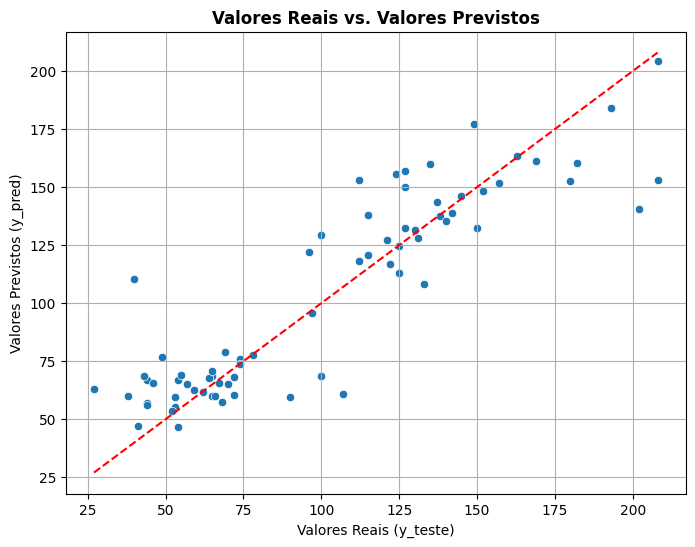

In [21]:
# --- FAZENDO PREVISÕES ---
y_pred = modelo.predict(X_teste)

# --- AVALIANDO O MODELO ---
mae = mean_absolute_error(y_teste, y_pred)
mse = mean_squared_error(y_teste, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_teste, y_pred)

print(f"--- Métricas de Avaliação do Modelo ---")
print(f"Erro Absoluto Médio (MAE): {mae:.2f} cliques")
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f} cliques")
print(f"Coeficiente de Determinação (R²): {r2:.2f}")

# --- AVALIAÇÃO VISUAL ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_teste, y=y_pred)
plt.xlabel("Valores Reais (y_teste)")
plt.ylabel("Valores Previstos (y_pred)")
plt.title("Valores Reais vs. Valores Previstos", fontweight='bold')

plt.plot([min(y_teste), max(y_teste)], [min(y_teste), max(y_teste)], color='red', linestyle='--')
plt.grid(True)
plt.show()

### Métricas de Avaliação do Modelo
Erro Absoluto Médio (MAE - Mean Absolute Error) é a média da diferença absoluta entre os valores reais e os previstos. Sendo assim, nosso modelo erra em média apenas 14 cliques, o que é muito bom se compararmos com a quantidade de valores de treino.

O Erro Quadrático Médio (MSE) é a média dos quadrados das diferenças. Ele penaliza erros maiores com mais força. É menos intuitivo porque a unidade está ao quadrado. Com isso, usamos o RMSE que é a raz quadrada do MSE, ou seja, a unidade volta a ser a original (ex: 'cliques'), tornando mais interpretável e similar ao MAE. A ideia é a mesma, e nosso modelo erra em média 18 cliques, o que continua excelente.


Coeficiente de Determinação (R2 - R-squared) mede a proporção da variação na variável alvo y (cliques link interno) que pode ser explicada pelas features X (impressões e gasto). O valor vai de 0 a 1 (ou pode ser negativo para modelos muito ruins).

**➥ Interpretação:** Um R2 de 0.85 significa que 85% da variação no número de cliques pode ser explicada pelo nosso modelo (usando gasto e impressões).

### Análise Gráfica da Performance do Modelo
A análise do gráfico de dispersão revela uma linearidade proeminente dos dados em relação à linha de referência tracejada. Essa observação indica um ajuste robusto do modelo, demonstrando sua eficácia na predição do valor alvo (y). A proximidade dos pontos de dados à linha de referência corrobora a alta performance preditiva do modelo atual.

Com o objetivo de otimizar ainda mais a precisão das previsões, será implementado um modelo preditivo mais robusto. Essa etapa visa aprimorar os resultados obtidos e finalizar o experimento com uma solução otimizada.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# --- TREINANDO O MODELO RANDOM FOREST ---
rf_modelo = RandomForestRegressor(n_estimators=100, 
                                  random_state=42, 
                                  n_jobs=-1)

rf_modelo.fit(X_treino, y_treino)
print("Modelo Random Forest treinado com sucesso!")

# --- AVALIAÇÃO ---
y_pred_rf = rf_modelo.predict(X_teste)

r2_rf = r2_score(y_teste, y_pred_rf)
mae_rf = mean_absolute_error(y_teste, y_pred_rf)

print(f"\n--- Métricas de Avaliação do Random Forest ---")
print(f"Erro Absoluto Médio (MAE): {mae_rf:.2f} cliques")
print(f"Coeficiente de Determinação (R²): {r2_rf:.2f}")

Modelo Random Forest treinado com sucesso!

--- Métricas de Avaliação do Random Forest ---
Erro Absoluto Médio (MAE): 14.85 cliques
Coeficiente de Determinação (R²): 0.83


---

### Avaliação do Modelo Random Forest e Implicações para a Campanha de Conversão

A execução do modelo **Random Forest** para a campanha de conversão sugere uma **relação predominantemente linear** entre as variáveis **gasto/impressões** e o **número de cliques**.

Verificou-se que a complexidade inerente ao algoritmo Random Forest não resultou em um ganho significativo no poder preditivo. Isso indica que a **Regressão Linear**, um modelo mais simples e com maior facilidade de interpretação, já se mostra **altamente eficaz e suficiente** para realizar as previsões nesta campanha específica. A escolha por um modelo mais parcimonioso, como a Regressão Linear, otimiza a interpretabilidade sem comprometer a acurácia para este cenário.

---


--- Importância das Features ---
      feature  importancia
0       gasto      0.86051
1  impressoes      0.13949


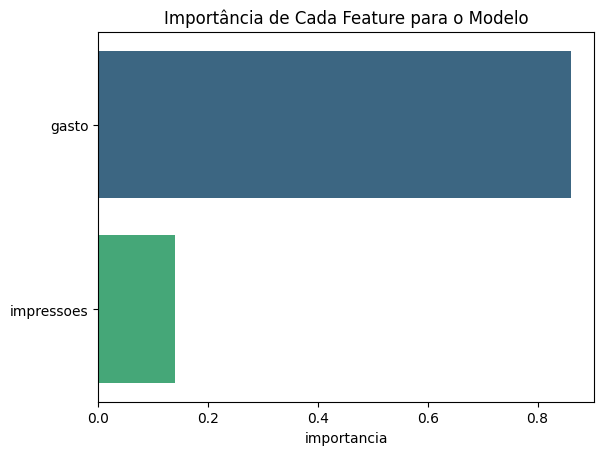

In [ ]:
# importância de cada feature do modelo treinado
importancias = rf_modelo.feature_importances_
features = X_treino.columns

# preparando DataFrame 
df_importancias = pd.DataFrame({'feature': features, 'importancia': importancias})
df_importancias = df_importancias.sort_values('importancia', ascending=False)

print("\n--- Importância das Features ---")
print(df_importancias)

# Plot
ax = sns.barplot(x='importancia',
                 y='feature', 
                 data=df_importancias, 
                 palette='viridis', 
                 hue='feature', 
                 legend=False)

plt.title('Importância de Cada Feature para o Modelo')
plt.ylabel('')
plt.show()

Em uma **campanha de conversão**, como a de reservas, o algoritmo da Meta opera de forma mais sofisticada. Ele é projetado para identificar e alcançar usuários com alta probabilidade de realizar a ação desejada. Nesse cenário, o investimento (`gasto`) emerge como a alavanca principal para impulsionar os resultados.

Com base nos dados analisados para esta campanha específica, comprovamos que o **investimento direto é, de fato, o motor principal para a geração de resultados**. Isso ocorre porque, quanto maior o investimento, mais o algoritmo da Meta consegue atuar dentro desse grupo seleto e qualificado de pessoas, gerando cliques de maior valor que se traduzem em conversões efetivas.

## Preparação de Dados para Clusterização K-Means

Para identificar **grupos naturais e ocultos** nos dados, será utilizada a técnica de **clusterização K-Means**.

É crucial observar a disparidade significativa nas escalas das métricas. Por exemplo, a métrica de "impressões" pode apresentar valores na casa dos milhares (ex: 4000, 5000), enquanto o "custo por clique (CPC)" pode ter valores unitários (ex: 6, 10).

Para mitigar essa diferença de magnitude e garantir que todas as *features* contribuam equitativamente para o processo de clusterização, será aplicado um **processo de *scaling***. Este pré-processamento padronizará as *features*, colocando-as em uma escala comparável antes da aplicação do algoritmo K-Means.

In [ ]:
from sklearn.preprocessing import StandardScaler

# --- CLUSTERIZAÇÃO COM K-MEANS ---
features_para_cluster = ['gasto', 'impressoes', 'numero de cliques', 'cpc', 'ctr']
df_cluster = df[features_para_cluster].dropna()

# --- APLICAR O SCALING ---
scaler = StandardScaler()

dados_escalados = scaler.fit_transform(df_cluster)
df_escalado = pd.DataFrame(dados_escalados, columns=features_para_cluster)

print("Dados originais (primeiras linhas):")
print(df_cluster.head())
print("\nDados escalados (primeiras linhas):")
print(df_escalado.head())

Dados originais (primeiras linhas):
   gasto  impressoes  numero de cliques       cpc       ctr
0  19.60        4508              122.0  0.110112  3.948536
1  19.53        4532              140.0  0.102251  4.214475
2  21.51        2829              157.0  0.119500  6.362672
3  21.82        2681              130.0  0.143553  5.669526
4  14.65        1751               51.0  0.164607  5.082810

Dados escalados (primeiras linhas):
      gasto  impressoes  numero de cliques       cpc       ctr
0 -0.170138   -0.125449           0.439103 -0.613231  0.078124
1 -0.177104   -0.120411           0.675578 -0.645482  0.196088
2  0.019940   -0.477883           0.898914 -0.574716  1.148980
3  0.050790   -0.508949           0.544203 -0.476037  0.841516
4 -0.662750   -0.704162          -0.493656 -0.389661  0.581262
